# Notebook de Exemplos: aproximando raízes de funções.

Este notebook demonstra o uso das seguintes funções de aproximação de raízes:

1.  `bissecao`: Aproxima a raíz utilizando o método da bisseção.

2.  `newton_raphson`: Aproxima a raíz utilizano o método Newton-Raphson.


# Código

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def bissecao(function, lower, upper, tolerance):

    '''
    Calcula a raiz aproximada de uma função usando o método da bisseção.

    =============

    Parâmetros :

    function : Função cuja raiz queremos encontrar, deve aceitar apenas um argumento x.

    lower : Limite inferior do intervalo em que queremos calcular a raiz da funçãp.

    upper : Limite superior do intervalo em que queremos calcular a raiz da função.

    tolerance : Valor mínimo que o intervalo pode assumir

    ============

    Retorna : 
    - Valor aproximado da raiz da função, arredondado para 3 casas decimais

    '''
    
    # Listas para salvar os dados para o gráfico. 
    lower_record = []
    upper_record = []
    # Adiciona nelas os valores iniciais
    lower_record.append(lower)
    upper_record.append(upper)

    # Avalia a função nos pontos limites do intervalo
    lower_bound = function(lower)
    upper_bound = function(upper)

    # Verifica se a função cumpre as condições para a utilização desse método
    if lower_bound * upper_bound >= 0:
        raise ValueError("A função não tem sinais opostos nos limites do intervalo.")
    
    while upper-lower > tolerance:
        
        #Calcula o ponto médio do intervalo
        medium_point = (lower + upper) / 2
        medium_value = function(medium_point)
        
        if medium_value == 0:
            return round(medium_point, 4)
        
        elif  lower_bound * function(medium_point) < 0:

            upper = medium_point
        else:
            lower = medium_point
            
        # Adiciona os novos pontos às listas de histórico
        lower_record.append(lower)
        upper_record.append(upper)
    
    x = np.linspace(lower_record[0], upper_record[0], 100)
    y = function(x)

    # Plota a função original em preto.    
    plt.plot(x, y, color = 'black', linewidth = 1, label = 'f(x)') 

    lower_points_y = function(np.array(lower_record))
    upper_points_y = function(np.array(upper_record))

    plt.plot(lower_record, lower_points_y, 'r>', label='Limite Inferior')
    plt.plot(upper_record, upper_points_y, 'b<', label='Limite Superior')

    # Plota o eixo x.
    plt.axhline(0, color='black', linewidth=1)

    # Configuração do gráfico
    plt.axis('equal')
    plt.title("Raízes da função pelo Método da Bisseção")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()

    # Quando o loop para, a função retorna a melhor estimativa, isto é, o ponto médio do último intervalo
    final_root = (lower + upper) / 2
    return round(final_root, 4)

def newton_raphson(function, guess, tolerance):
    
    """
    Encontra uma raiz de uma função real usando o método de Newton–Raphson.
    
    ----------

    Parâmetros
    
    function : callable ou sympy
        Função cuja raíz queremos encontrar ou aproximar. Deve ser uma função real de variável real,
        ou seja, aceita um único argumento (float).
        Pode ser:
         - um callable Python (por exemplo, lambda x: x**2 - 2) que usa operações com floats/numpy, ou
         - uma expressão SymPy (por exemplo, sp.sympify("x**2 - 2")) ou sp.Lambda.
        ***IMPORTANTE: para melhor eficiência do método, prefira usar funções sympy!!!
    guess : float
        Chute inicial x0.
    tolerance : float
        Critério de parada. O algoritmo para quando |f(x)| < tolerance ou |dx| < tolerance.
    
    ----------
    
    Retorna
    
    uma aproximação da raiz.
    
    um plot do método.
    
    ----------

    Possíveis mensagens de erro
    
    ZeroDivisionError se a derivada (praticamente) zerar durante a iteração.
    ValueError se a função produzir NaN/Inf no chute.
    RuntimeError se não convergir dentro de um número máximo de 1000 iterações.

    """

    MAX_ITERS = 1000
    x0 = float(guess)
    x_record = [x0]

    # Preparar f e df: se function for sympy, obtenha a derivada analítca;
    # caso contrário, use derivada numérica por quociente de newton.
    if isinstance(function, sp.Basic):  # cobre sp.Expr, sp.Symbol, etc.
        if isinstance(function, sp.Lambda):
            f_expr = function.expr
            variables = function.variables
        else: # é uma expressão sp.Basic
            f_expr = function
            variables = function.free_symbols

        # Garante que é uma função de uma variável
        if len(variables) == 0:
            # Caso constante
            f = lambda x: float(f_expr)
            df = lambda x: 0.0
        elif len(variables) == 1:
            x_sym = list(variables)[0]
            f = sp.lambdify(x_sym, f_expr, 'numpy')
            
            df_expr = sp.diff(f_expr, x_sym)
            df = sp.lambdify(x_sym, df_expr, 'numpy')
        else:
            raise ValueError(f"A expressão SymPy deve ter exatamente uma variável, mas foram encontradas {len(variables)}: {variables}")
        
    elif callable(function):
        f = function
        def df(x):
            h = 1e-8
            return (f(x + h) - f(x - h)) / (2.0 * h)
    
    # Caso 3: Entrada inválida
    else:
        raise TypeError("function deve ser um callable (ex: lambda) ou uma expressão SymPy (Expr ou Lambda).")
    
    root = None
    for i in range(MAX_ITERS):
        fx = float(f(x0))
        if np.isnan(fx) or np.isinf(fx):
            raise ValueError(f"f(x) retornou {fx} no ponto x = {x0}.")
        # critério pelo valor da função
        if abs(fx) < tolerance:
            root = x0
            break
        dfx = float(df(x0))
        if np.isnan(dfx) or np.isinf(dfx):
            raise ValueError(f"f'(x) retornou {dfx} no ponto x = {x0}.")
        if abs(dfx) < 1e-16:
            raise ZeroDivisionError(f"Derivada muito próxima de zero em x = {x0}.")
        x1 = x0 - fx / dfx
        x_record.append(x1)
        # critério pelo passo
        if abs(x1 - x0) < tolerance:
            root = x1
            break
        x0 = x1
    
    if root is None:
        raise RuntimeError(f"Não convergiu após {MAX_ITERS} iterações. Último x = {x0}, f(x) = {fx}")
    
    # Visualização gráfica
    if len(x_record) > 1:
        x_min = min(x_record)
        x_max = max(x_record)
        delta = (x_max - x_min) * 0.1 if x_max > x_min else 1.0
        x_min -= delta
        x_max += delta
    else:
        x_min = x_record[0] - 1.0
        x_max = x_record[0] + 1.0
    
    x = np.linspace(x_min, x_max, 100)
    y = f(x)
    
    # Plota a função original em preto.
    plt.plot(x, y, color='black', linewidth=1, label='f(x)')
    
    # Plota os pontos de iteração
    x_points_y = f(np.array(x_record))
    plt.plot(x_record, x_points_y, 'ro', label='Pontos de Iteração')
    
    # Plota os segmentos de reta tangente pontilhados
    for j in range(len(x_record) - 1):
        x_i = x_record[j]
        y_i = float(f(x_i))
        x_next = x_record[j + 1]
        x_tang = np.array([x_i, x_next])
        y_tang = df(x_i) * (x_tang - x_i) + y_i
        plt.plot(x_tang, y_tang, 'b--', label='Tangente' if j == 0 else None)
    
    # Plota o eixo x.
    plt.axhline(0, color='black', linewidth=1)
    
    # Configuração do gráfico
    plt.axis('equal')
    plt.title("Raízes da função pelo Método de Newton-Raphson")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()
    
    return round(root, 4)

# Testes com o método da bisseção.

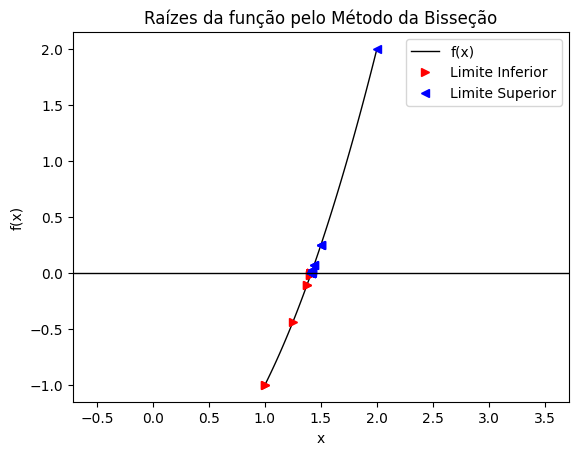

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [36]:
# Função para aproximar a raiz:
f = lambda x: x**2 - 2

# Parâmetros:
limite_inferior = 1.0
limite_superior = 2.0
tolerância = 1e-8

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: sqrt(2)")

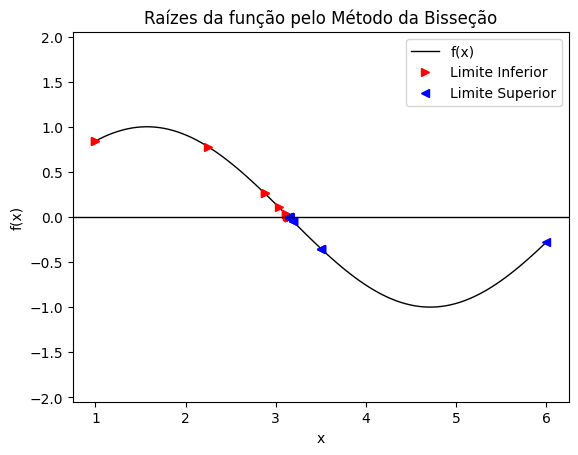

Raiz aproximada: 3.1416
Raiz exata: pi


In [37]:
# Função para aproximar a raiz:
f = lambda x: np.sin(x)

# Parâmetros:
limite_inferior = 1
limite_superior = 6
tolerância = 1e-7

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: pi")

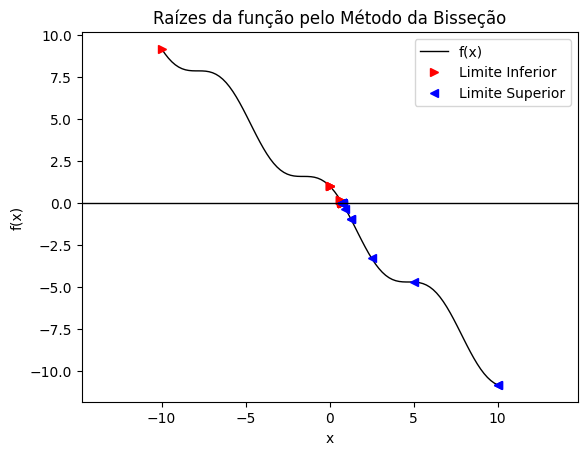

Raiz aproximada: 0.7391


In [38]:
# Função para aproximar a raiz:
f = lambda x: np.cos(x) - x

# Parâmetros:
limite_inferior = -10
limite_superior = 10
tolerância = 1e-9

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")

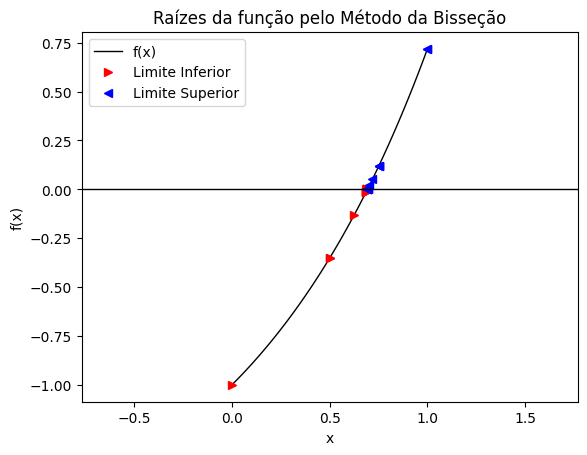

Raiz aproximada: 0.6931
Raiz exata: ln(2)


In [39]:
# Função para aproximar a raiz:
f = lambda x: np.exp(x) - 2

# Parâmetros:
limite_inferior = 0
limite_superior = 1
tolerância = 1e-8

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: ln(2)")

# Testes com o método Newton-Raphson.

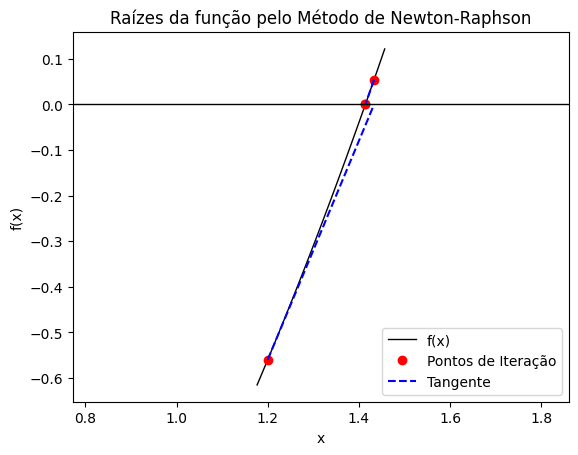

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [40]:
# Função para aproximar a raiz:
f = sp.sympify("x**2 - 2")

# Parâmetros:
chute = 1.2
tolerância = 1e-6

# Aproximação da raíz:
root = newton_raphson(f, chute, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print("Raiz exata: sqrt(2)")

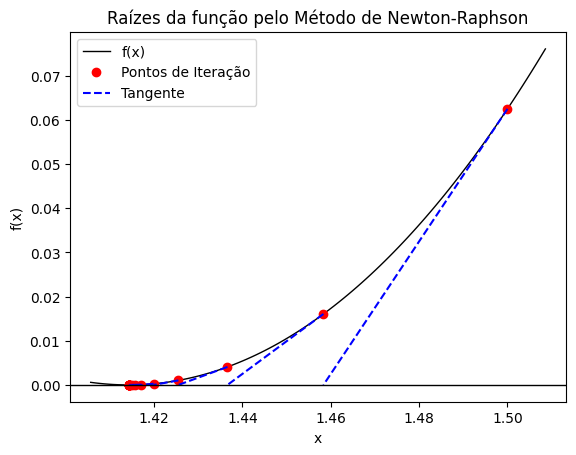

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [41]:
# Função para aproximar a raiz:

f = sp.sympify("x**4 - 4*x**2 + 4")

# Parâmetros:

chute = 1.5
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")
print("Raiz exata: sqrt(2)")


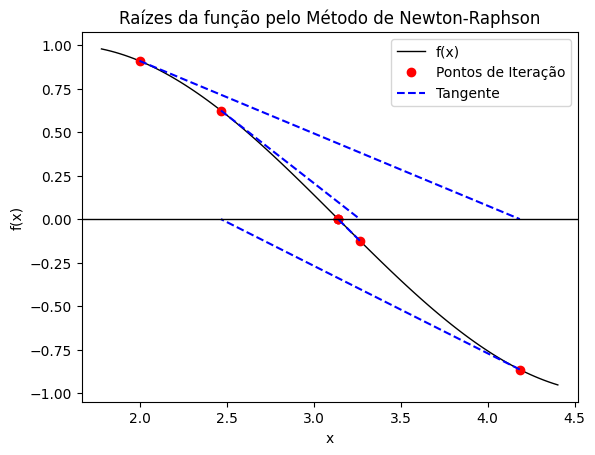

Raiz aproximada: 3.1416
Raiz exata: pi


In [42]:
# Função para aproximar a raiz:

f = sp.sympify("sin(x)")

# Parâmetros:

chute = 2
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")
print("Raiz exata: pi")


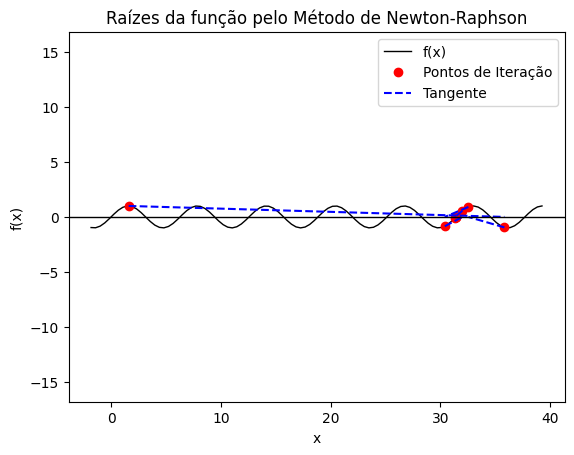

Raiz aproximada: 31.4159


In [43]:
# Função para aproximar a raiz:

f = sp.sympify("sin(x)")

# Parâmetros:

chute = 1.6
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")